In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

Read the different file types: pb-tags indicate pressure level files, pc-tags indicate pure surface files.
Past is 1980 vegetation, current is 2010. 
Topography and vegetation information is saved in ancillaries folder 'ancils'.

In [37]:
VERA_data_dir = '/home/ck/DIR/cornkle/data/vera_out/'

pl_files_current = glob.glob(VERA_data_dir+'current*pb*.nc')
pl_files_past = glob.glob(VERA_data_dir+'past*pb*.nc')
surface_files_current = glob.glob(VERA_data_dir+'current*pc*.nc')
surface_files_past = glob.glob(VERA_data_dir+'past*pc*.nc')
ancil_path = VERA_data_dir + 'ancils/'

In [38]:
def griddata_lin(indata, x, y, new_x, new_y):

    """
    This function linearly interpolates a 2d input array, which can be on a irregular grid, onto a given regular grid. 
    :param x: current x variables (1 or 2d, definitely 2d if irregular!)
    :param y: current y variables (1 or 2d, definitely 2d if irregular!)
    :param new_x: target x vars
    :param new_y: target y vars
    :return:  triangulisation lookup table, point weights, 2d shape - inputs for interpolation func
    """

    if x.ndim == 1:
        grid_xs, grid_ys = np.meshgrid(x, y)
    else:
        grid_xs = x
        grid_ys = y

    if new_x.ndim == 1:
        new_xs, new_ys = np.meshgrid(new_x, new_y)
    else:
        new_xs = new_x
        new_ys = new_y

    points = np.array((grid_xs.flatten(), grid_ys.flatten())).T
    inter = np.array((np.ravel(new_xs), np.ravel(new_ys))).T
    shape = new_xs.shape

    # Interpolate using delaunay triangularization
    indata = griddata(points, indata.flatten(), inter, method='linear')
    outdata = indata.reshape((shape[0], shape[1]))

    return outdata

In [39]:
def u_v_to_ws_wd(u,v):
    """
    This function computes wind speed and wind direction from given u,v wind components
    Wind direction indicates where the wind is coming from. 
    :param u:
    :param v:
    :return: tuple (wind speed, wind direction (convention "wind coming from")
    """

    ws = np.array(np.sqrt(u*u + v*v))
    wd = np.array(180. + np.arctan2(u, v) * 180./ np.pi)  # dir where wind is coming from
    pos = np.where(ws == 0)
    try:
        wd[pos] = np.nan
    except IndexError:
        pass

    return ws,wd

In [40]:
study_box = [-15,10, 3,15]

In [41]:
test_file = xr.open_dataset(surface_files_current[0])
srfc_cur = xr.open_mfdataset(surface_files_current)
srfc_past = xr.open_mfdataset(surface_files_past)
pl_cur = xr.open_mfdataset(pl_files_current)
pl_past = xr.open_mfdataset(pl_files_past)

In [42]:
u = pl_cur['u10']
v = pl_cur['v10']

In [43]:
rain = srfc_cur['TotalRain']

In [46]:
srfc_cur.TotalRain.values.max()*3600

87.02717497944832

(array([1449536.,  529016.,  280776.,  181823.,  124791.,   82595.,
          53909.,   36147.,   23838.,   15509.]),
 array([ 1,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
 <a list of 10 Patch objects>)

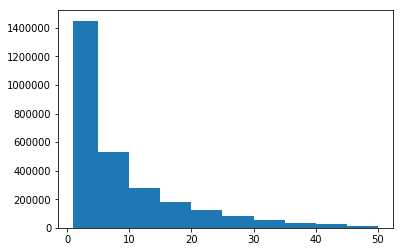

In [56]:
plt.hist((srfc_cur.TotalRain.values.flatten())*3600, bins=[1,5,10,15,20,25,30,35,40,45,50])

In [10]:
# decode_times=False is needed because the ancils have no real time step and without it
# xarray would try to read the time, fail, and then give an error. With the keyword however you can read it. 

# veg_current = xr.open_dataset(ancil_path + 'current_veg.nc', decode_times=False)
# veg_past = xr.open_dataset(ancil_path + 'past_veg.nc', decode_times=False)
# topo = xr.open_dataset(ancil_path + 'topo.nc', decode_times=False) 

all_ancil =xr.open_dataset(ancil_path + 'ancils_vera.nc', decode_times=False) 

In [11]:
cur = srfc_cur['TotalRain'].groupby('time.hour').mean('time')
past = srfc_past['TotalRain'].groupby('time.hour').mean('time')

u = u.groupby('time.hour').mean('time')
v = v.groupby('time.hour').mean('time')

In [12]:
wspeed, wdir = u_v_to_ws_wd(u,v)

In [13]:
### this is a dirty way of creating regular lat/lons without data interpolation
cur.false_latitude.values = cur.true_latitude.mean(axis=1)
cur.false_longitude.values = cur.true_longitude.mean(axis=0)
past.false_latitude.values = past.true_latitude.mean(axis=1)
past.false_longitude.values = past.true_longitude.mean(axis=0)

In [14]:
## a better, cleaner way (where you have more control) - use matplotlib functions directly

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list [lon,lat,u,v,scale]
    if quiver is not None:
        qu = ax.quiver(quiver[0], quiver[1], quiver[2], quiver[3], scale=quiver[4])
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    plt.colorbar(mapp)  # adds colorbar
    plt.show()   

## notice that I used the "true latitude", "true longitude" variables as dimensions! 
## also notice the white regions in this plot, this happens due to the respresentation on lat/lons.

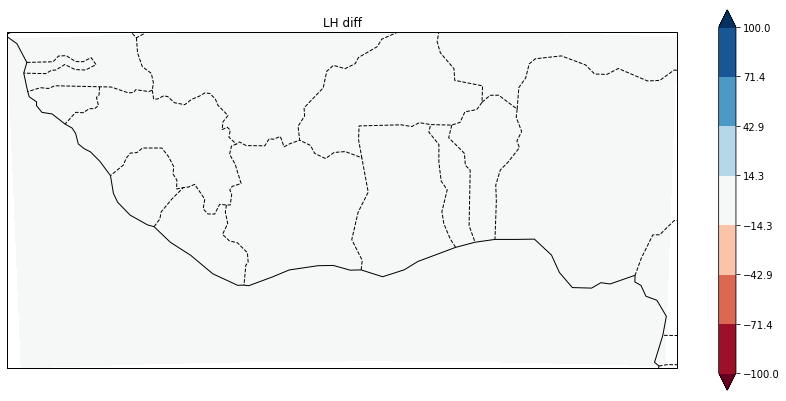

In [15]:
lon=test_file.true_longitude
lat=test_file.true_latitude
data=(cur-past).sel(hour=slice(12,17)).mean('hour')
data2=all_ancil['veg_current']-all_ancil['veg_past']
title='LH diff'

f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
plt.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=np.linspace(-100,100,8), extend='both', cmap='RdBu')  # this is the actual plot
#plt.contour(lon,lat,data2,transform=ccrs.PlateCarree(), levels=[0.3,0.4])
ax.coastlines()   ## adds coastlines
# Gridlines
# xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
# xl.xlabels_top = False   ## labels off
# xl.ylabels_right = False
plt.title(title)
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
plt.colorbar()  # adds colorbar
plt.show()

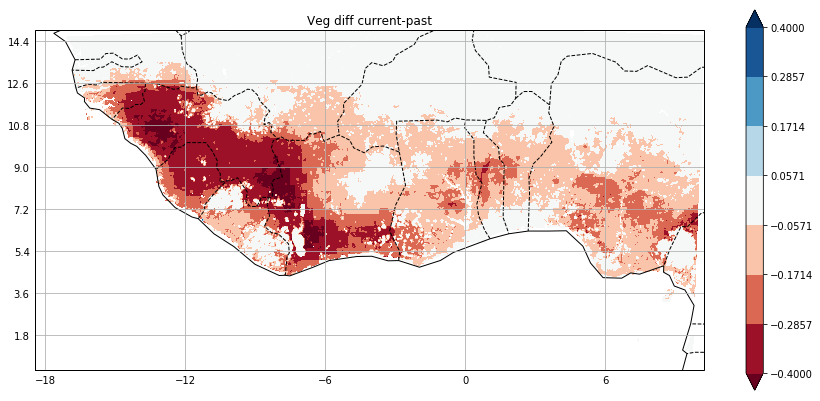

In [16]:
draw_map(data2, lon, lat, title='Veg diff current-past', levels=np.linspace(-0.4,0.4,8), extend='both', cmap='RdBu')

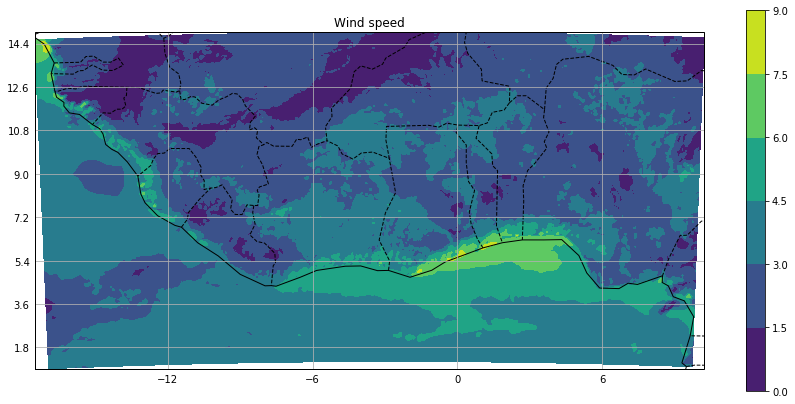

In [17]:
draw_map(wspeed[15,:,:],lon,lat, title='Wind speed')

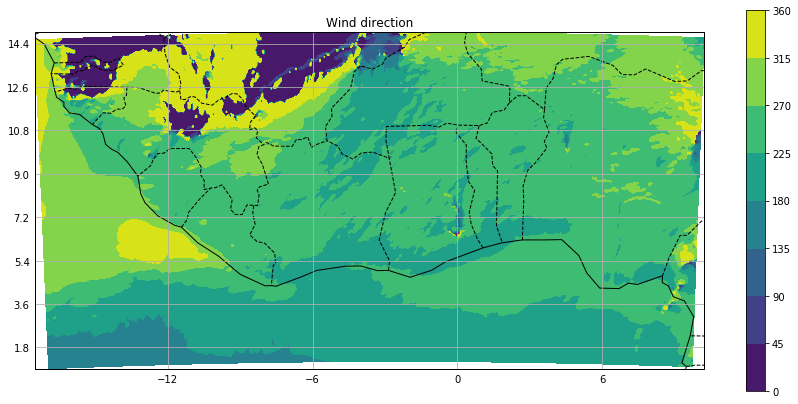

In [18]:
draw_map(wdir[15,:,:],lon,lat, title='Wind direction', levels=np.arange(0,361,45))

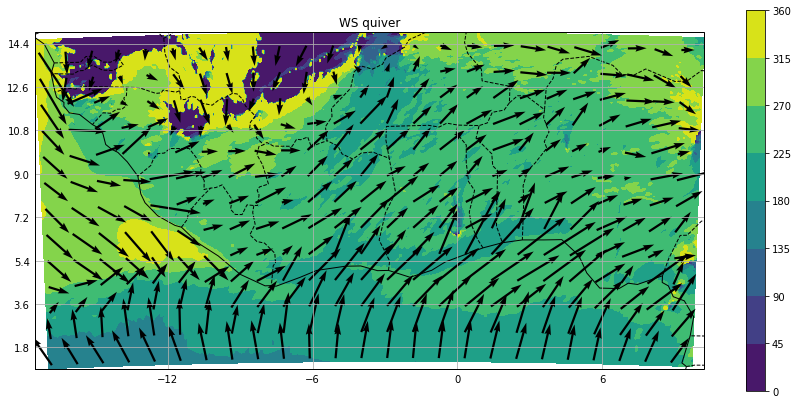

In [19]:
st=30
sarrow = 4
xquiv = u.true_longitude[sarrow::st, sarrow::st]
yquiv = u.true_latitude[sarrow::st, sarrow::st]

uu = (u[15,:,:])[sarrow::st, sarrow::st]
vv = (v[15,:,:])[sarrow::st, sarrow::st]


draw_map(wdir[15,:,:], lon, lat, title='WS quiver', quiver=[xquiv,yquiv,uu,vv,70],levels=np.arange(0,361,45))

In [20]:
new_lon = np.arange(-17,10.1,0.25)
new_lat = np.arange(1,14.1,0.25)
new_data = griddata_lin(data.values, lon.values, lat.values, new_lon, new_lat)

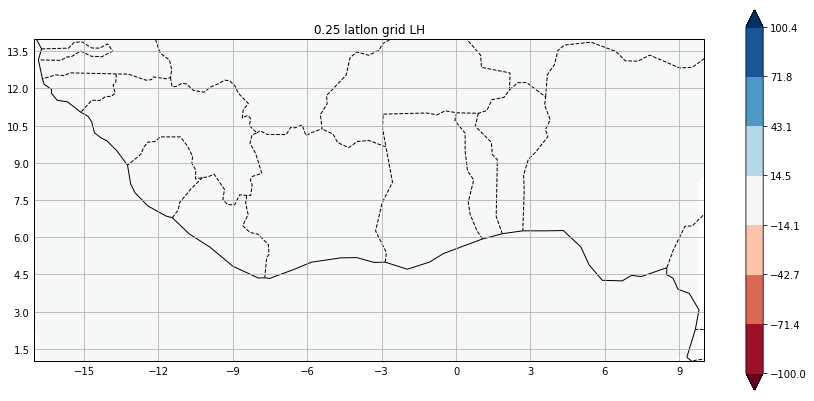

In [21]:
draw_map(new_data, new_lon, new_lat, title='0.25 latlon grid LH', levels=np.linspace(-100,100.4,8), extend='both', cmap='RdBu')

In [22]:
current_runs = ['xmhkga', 'xmhkka', 'xmhkma', 'xmhkoa']
past_runs = ['xmhkja', 'xmhkla', 'xmhkna', 'xmhkpa']

In [33]:
diff_da = None
var = 'SH'

def collect(container, data, dim_name):
    if container is not None:
        container = xr.concat([container,data], dim_name)
    else:
        container = data
    
    return container


for cur, pas in itertools.product(current_runs, past_runs):
    surface_files_current = glob.glob(VERA_data_dir+'current_'+cur+'.pc*.nc')
    surface_files_past = glob.glob(VERA_data_dir+'past_'+pas+'.pc*.nc')
    
    srfc_cur = xr.open_mfdataset(surface_files_current)
    srfc_past = xr.open_mfdataset(surface_files_past)
    
    cur = srfc_cur[var].groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
    past = srfc_past[var].groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
        
    diffs = cur-past
    diff_da = collect(diff_da, diffs, 'cur-past')

arstack_cur = None
arstack_past = None    

for cur, pas in zip(current_runs, past_runs):
    surface_files_current = glob.glob(VERA_data_dir+'current_'+cur+'.pc*.nc')
    surface_files_past = glob.glob(VERA_data_dir+'past_'+pas+'.pc*.nc')
    
    srfc_cur = xr.open_mfdataset(surface_files_current)
    srfc_past = xr.open_mfdataset(surface_files_past)
    
    cur = srfc_cur[var].groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
    past = srfc_past[var].groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
#     cur = (srfc_cur['SH'])[srfc_cur['time.hour'] == 15]
#     past = (srfc_past['SH'])[srfc_past['time.hour'] == 15]

    arstack_cur = collect(arstack_cur, cur, 'cur')
    arstack_past = collect(arstack_past, past, 'cur')


In [34]:
tstat, pval = stats.ttest_ind(arstack_cur, arstack_past, axis=0)
amask = (pval<=0.01).astype(int)

/home/ck/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


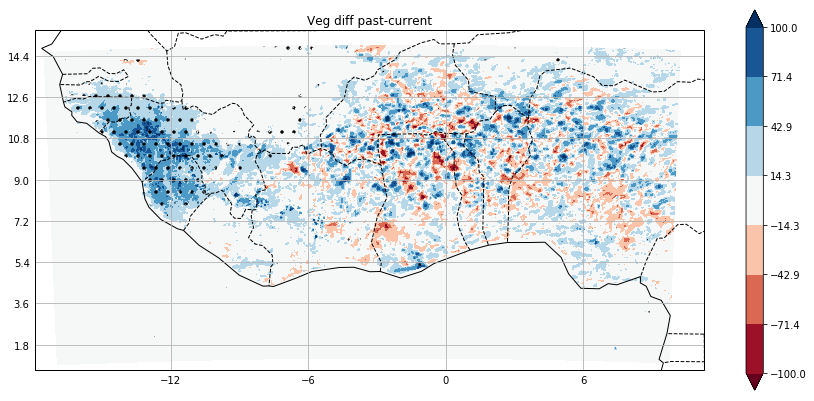

In [35]:
draw_map(diff_da.mean('cur-past'), diff_da.true_longitude, diff_da.true_latitude, title='Veg diff past-current', levels=np.linspace(-100,100,8), extend='both', cmap='RdBu', mask_sig=amask)

In [26]:
for pas in past_runs:
    surface_files_past = glob.glob(VERA_data_dir+'past_'+pas+'_pc*.nc')
    srfc_past = xr.open_mfdataset(surface_files_past)
    past = srfc_past['LH'].groupby('time.hour').mean('time').sel(hour=18)
    if arstack_past not None:
        arstack_past = np.concatenate([arstack_past, past], dim=0)
    else:
        arstack_past = np.array(past)[:]

SyntaxError: invalid syntax (<ipython-input-26-5f3c7bb59a71>, line 5)